# AIPI 590 - XAI | Assignment #04
### Interpretable Machine Learning Models: FIGS, RF+/MDI+, and Hierarchical Shrinkage
### Akhil Chintalapati

#### Click the button below to open the notebook in Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AkhilByteWrangler/AIPI590_InterpretableML_Assignment4/blob/main/Interpretable_ML_Models_AIPI590.ipynb)


## Citations
This project utilizes publicly available models and resources from the imodels (https://github.com/csinva/imodels) library. All models, including FIGS, RF+/MDI+, and Hierarchical Shrinkage, are used strictly for educational and research purposes, in accordance with the licenses provided by their respective authors and contributors.

The materials from the following sources are used under the rights granted for academic and non-commercial use:

* Tan, Y. S., Singh, C., Nasseri, K., Agarwal, A., Duncan, J., Ronen, O., ... & Yu, B. (2023). Fast interpretable greedy-tree sums (FIGS). arXiv preprint
* Agarwal, A., Kenney, A. M., Tan, Y. S., Tang, T. M., & Yu, B. (2023). MDI+: A flexible random forest-based feature importance framework. arXiv preprint.
Agarwal, A., Tan, Y. S., Ronen, O., Singh, C., & Yu, B. (2022, June).
* Hierarchical Shrinkage: Improving the accuracy and interpretability of tree-based models. In International Conference on Machine Learning.

This project is distributed solely for academic review and educational purposes and complies with open-access guidelines.

## 1. Importing Necessary Libraries

In [1]:
%pip --quiet install pandas numpy seaborn matplotlib plotly scikit-learn imodels

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Import necessary modules from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.tree import plot_tree

# Import interpretable models from the imodels library
from imodels import FIGSClassifier, HSTreeClassifierCV  # Two interpretable models from imodels library
from imodels.importance import RandomForestPlusClassifier  # Another model focusing on feature importance

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.0/243.0 kB 7.1 MB/s eta 0:00:00


## 2. Loading and Preprocessing the Dataset

In [2]:
# Load the Palmer Penguins dataset using seaborn (https://github.com/mwaskom/seaborn-data/blob/master/penguins.csv)
# This dataset contains measurements for penguin species, island, bill length, flipper length, etc.
penguins = sns.load_dataset("penguins")

# Quick look
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [3]:
# Function to impute missing values in the dataset
def impute_missing_values(df):
    """
    Imputes missing values in the dataset.
    For numerical columns, missing values are replaced with the mean of that column.
    For categorical columns, missing values are replaced with the mode (most frequent value).

    After imputation, the function checks for any remaining missing values.

    Parameters:
    df (DataFrame): The dataframe containing missing values to be imputed.

    Returns:
    DataFrame: The dataframe with missing values imputed.
    """

    numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

    # Impute missing values for numerical columns using mean
    imputer = SimpleImputer(strategy='mean')
    df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

    # Impute missing values for the 'sex' column (categorical) using mode
    df['sex'].fillna(df['sex'].mode()[0], inplace=True)

    missing_after_imputation = df.isna().sum()
    print("Missing values after imputation:\n", missing_after_imputation)

    return df

penguins = impute_missing_values(penguins)

# Checking the result to ensure no more missing values
penguins.head()

Missing values after imputation:
 species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.10000,18.70000,181.000000,3750.000000,Male
1,Adelie,Torgersen,39.50000,17.40000,186.000000,3800.000000,Female
2,Adelie,Torgersen,40.30000,18.00000,195.000000,3250.000000,Female
3,Adelie,Torgersen,43.92193,17.15117,200.915205,4201.754386,Male
4,Adelie,Torgersen,36.70000,19.30000,193.000000,3450.000000,Female


In [4]:
# Convert categorical columns using one-hot encoding for 'island' and 'sex'
penguins_encoded = pd.get_dummies(penguins, columns=['island', 'sex'], drop_first=True)

# Define the feature matrix X and the target variable y (the species column will be our target variable)
X = penguins_encoded.drop('species', axis=1)  # Features: drop the 'species' column
y = penguins['species']  # Target: the species column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Quick Look
X_train.head()

Training set shape: (275, 7)
Test set shape: (69, 7)


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
66,35.5,16.2,195.0,3350.0,False,False,False
229,46.8,15.4,215.0,5150.0,False,False,True
7,39.2,19.6,195.0,4675.0,False,True,True
140,40.2,17.1,193.0,3400.0,True,False,False
323,49.1,15.0,228.0,5500.0,False,False,True


## 3. Helper Functions for Evaluation and Visualisation

In [5]:
# Helper function to evaluate the model performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluates the model on the test set and prints accuracy, classification report, and confusion matrix.
    """
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    y_pred = np.array(y_pred)

    # Print evaluation metrics
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Helper function to plot feature importances
def plot_feature_importances(importances, feature_names, title):
    """
    Plots the feature importances of a given model.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=feature_names)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

## 4. Models

Model: RandomForestPlusClassifier
Accuracy: 0.97
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        32
   Chinstrap       1.00      0.94      0.97        16
      Gentoo       0.95      1.00      0.98        21

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69

Confusion Matrix:
[[31  0  1]
 [ 1 15  0]
 [ 0  0 21]]


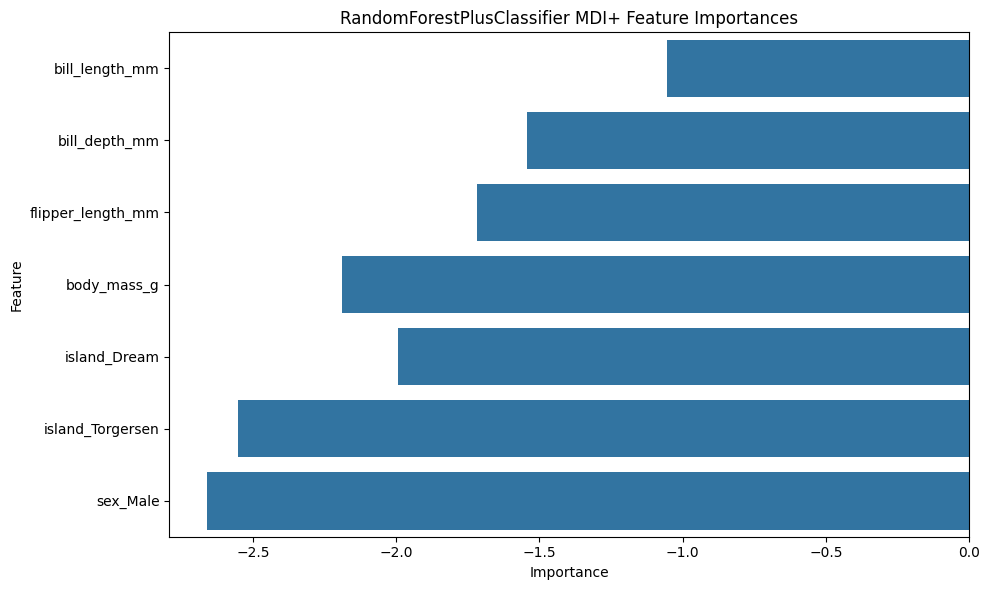

In [6]:
### Models Implementation ###

# Convert boolean columns to integers (0 and 1)
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes('bool').columns})

# 1. RandomForestPlusClassifier / MDIPlus (https://csinva.io/imodels/mdi_plus.html)
rf_plus_model = RandomForestPlusClassifier()
rf_plus_model.fit(X_train, y_train.values)  # Fit the model to training data

# Evaluate the RandomForestPlusClassifier
evaluate_model(rf_plus_model, X_train, X_test, y_train.values, y_test.values)

# Extract feature importance using MDI+ (Mean Decrease Impurity Plus)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train.values)

# Extract feature names and importance scores
feature_names = mdi_plus_scores['var'].values
importance_scores = mdi_plus_scores['importance'].values

if len(importance_scores) != len(feature_names):
    print(f"Error: The number of feature importances ({len(importance_scores)}) does not match the number of features ({len(feature_names)})")
else:
    plot_feature_importances(importance_scores, feature_names, 'RandomForestPlusClassifier MDI+ Feature Importances')

Model: FIGSClassifier
Accuracy: 0.64
              precision    recall  f1-score   support

      Adelie       0.97      0.91      0.94        32
   Chinstrap       0.38      0.94      0.55        16
      Gentoo       0.00      0.00      0.00        21

    accuracy                           0.64        69
   macro avg       0.45      0.61      0.49        69
weighted avg       0.54      0.64      0.56        69

Confusion Matrix:
[[29  3  0]
 [ 1 15  0]
 [ 0 21  0]]


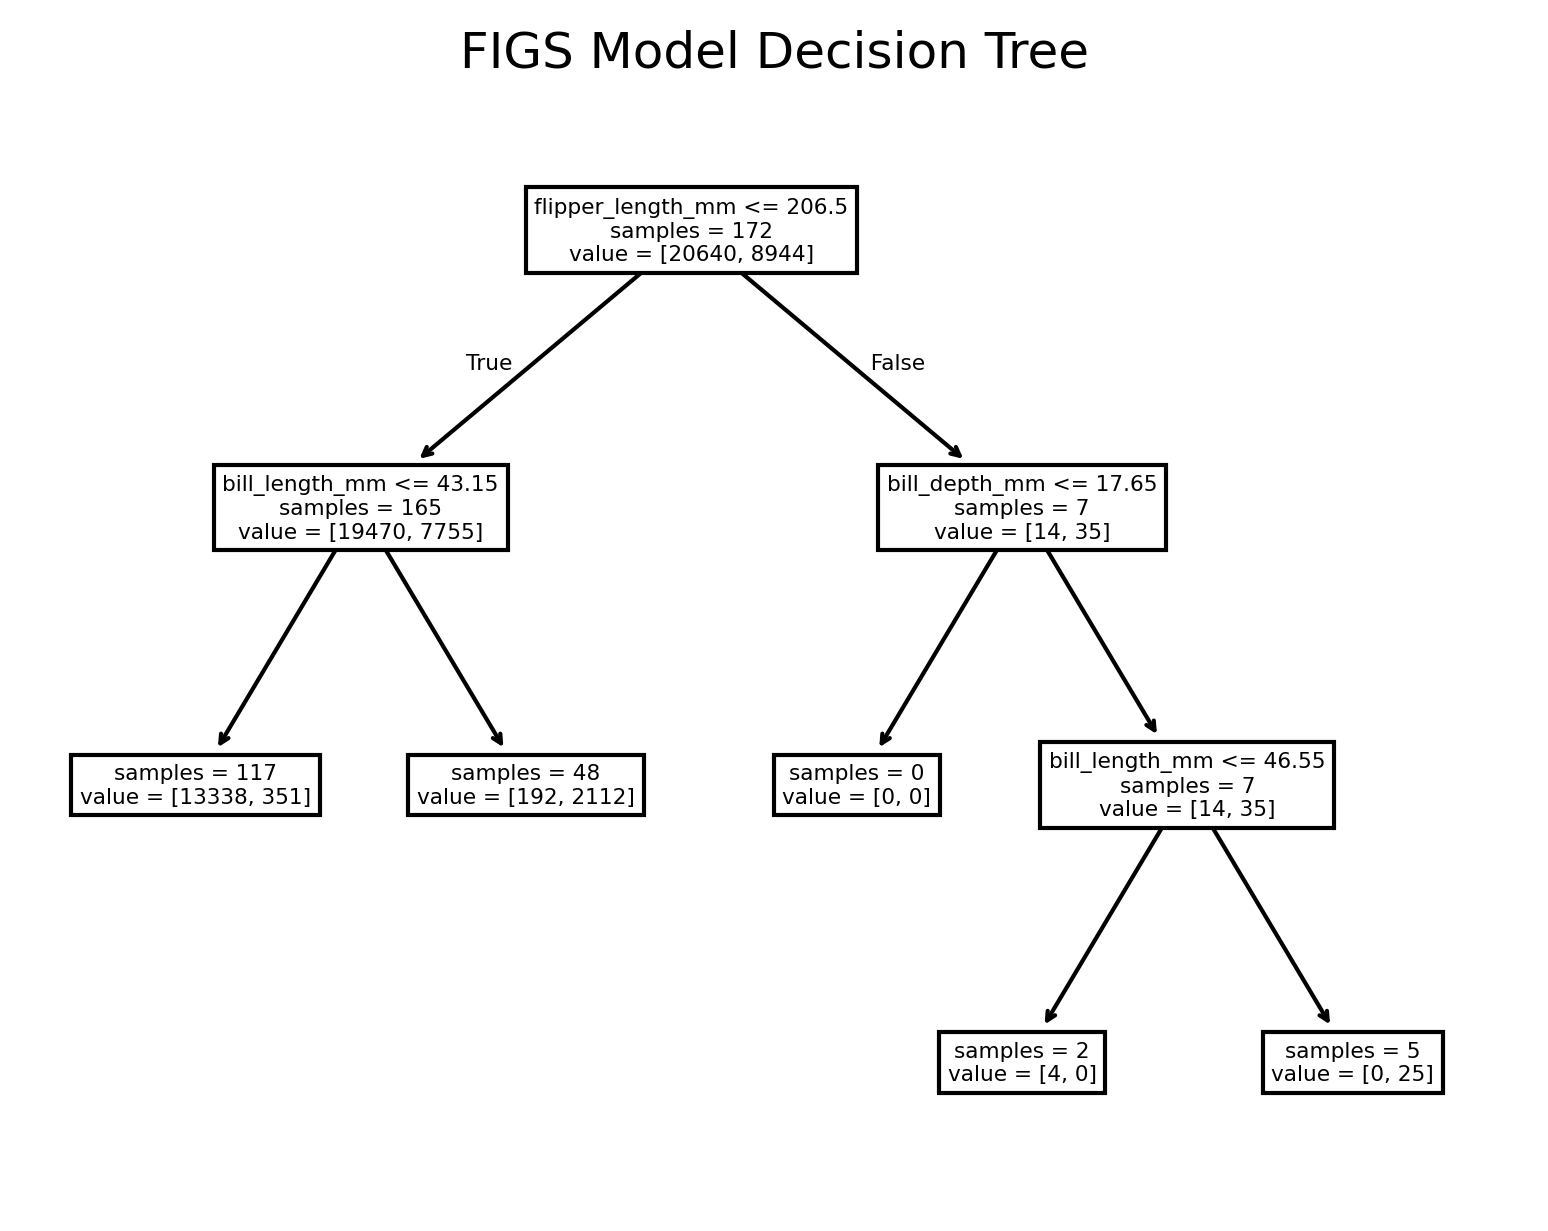

In [7]:
# 2. FIGSClassifier (Flexible Interpretable Generalized Surrogate) (https://csinva.io/imodels/figs.html)
figs_model = FIGSClassifier(max_rules=4)  # Initialize FIGS model with max rules
figs_model.fit(X_train, y_train.values)  # Fit the model to training data

# Evaluate the FIGSClassifier
evaluate_model(figs_model, X_train, X_test, y_train.values, y_test.values)

# Visualize the FIGSClassifier decision rules
figs_model.plot(feature_names=X.columns, filename='figs_rules.svg', dpi=300)

plt.title('FIGS Model Decision Tree')
plt.show()

Model: HSTreeClassifierCV
Accuracy: 0.97
              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        32
   Chinstrap       1.00      0.94      0.97        16
      Gentoo       1.00      0.95      0.98        21

    accuracy                           0.97        69
   macro avg       0.98      0.96      0.97        69
weighted avg       0.97      0.97      0.97        69

Confusion Matrix:
[[32  0  0]
 [ 1 15  0]
 [ 1  0 20]]


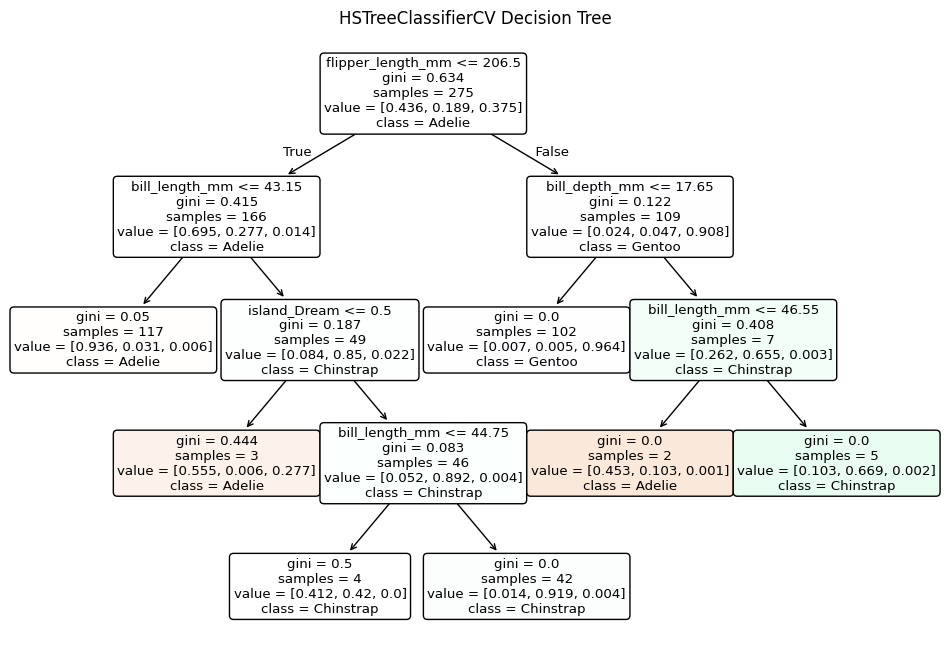

In [8]:
# 3. HSTreeClassifierCV (Hierarchical Shrinkage Tree Classifier with Cross-Validation) (https://csinva.io/imodels/shrinkage.html)
hs_tree_model = HSTreeClassifierCV(max_leaf_nodes=7)  # Initialize the model

# Convert X_train, X_test, y_train, and y_test to NumPy arrays
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Fit the model to the training data
hs_tree_model.fit(X_train_np, y_train_np)

# Evaluate the model on the test set
evaluate_model(hs_tree_model, X_train_np, X_test_np, y_train_np, y_test_np)

plt.figure(figsize=(12, 8))
plot_tree(hs_tree_model.estimator_,
          feature_names=X_train.columns,
          class_names=['Adelie', 'Chinstrap', 'Gentoo'],
          filled=True,
          rounded=True,
          proportion=False)
plt.title("HSTreeClassifierCV Decision Tree")
plt.show()